In [234]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.color import rgb2hsv
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_multiotsu
import skimage.morphology as skmorph
import pandas as pd
from skimage.morphology import flood_fill
from skimage.util import invert
from skimage.filters import gaussian
from skimage.segmentation import active_contour


# Dermatitis analysis
## RGB analysis

(222, 294, 3)


(<AxesSubplot:title={'center':'blue'}>,
 Text(0.5, 1.0, 'blue'),
 (-0.5, 293.5, 221.5, -0.5))

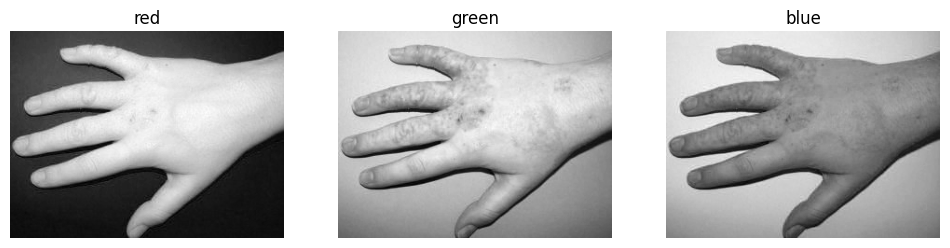

In [235]:
img = skio.imread('atopic_dermatitis_hand.jpg', as_gray=False) # CHANGE FILENAME
print(img.shape)
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(img[:, :, 0], cmap='gray'), plt.title('red'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(img[:, :, 1], cmap='gray'), plt.title('green'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(img[:, :, 2], cmap='gray'), plt.title('blue'), plt.axis('off')

### Red channel histogram

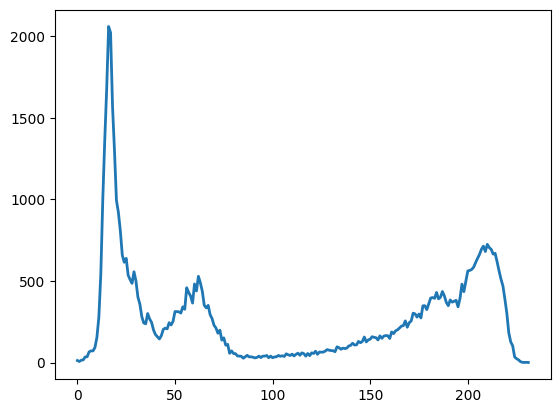

In [236]:
hist, hist_centers = exposure.histogram(img[:, :, 0])
plt.figure()
plt.plot(hist_centers, hist, lw=2)

### Green channel histogram

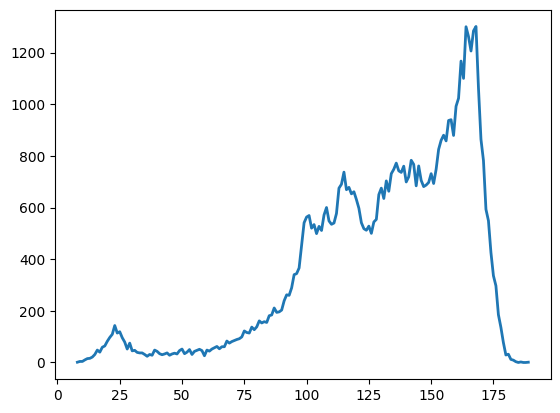

In [237]:
hist, hist_centers = exposure.histogram(img[:, :, 1])
plt.figure()
plt.plot(hist_centers, hist, lw=2)

In [238]:
skio.imsave('red_channel.png', img[:, :, 0])
skio.imsave('green_channel.png', img[:, :, 1])

## Otsu thresholding to create background mask

(<matplotlib.image.AxesImage at 0x2d34322f640>,
 Text(0.5, 1.0, 'Otsu thresholded mask'),
 (-0.5, 293.5, 221.5, -0.5))

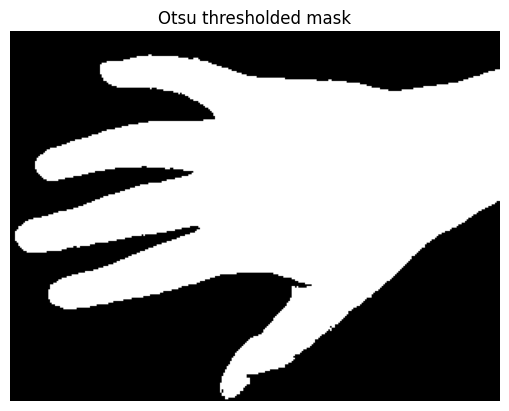

In [239]:
threshold = threshold_otsu(img[:, :, 0])
mask = img[:, :, 0] > threshold
plt.imshow(mask, cmap='gray'), plt.title('Otsu thresholded mask'), plt.axis('off')

## Segment background of green channel using the mask


In [240]:
def select_hand(mask, hand_img, channels=1, dtype='uint8'):
    if dtype == 'uint8':
        selected_img = np.zeros(hand_img.shape).astype('uint8')
    elif dtype == 'float64':
        selected_img = np.zeros(hand_img.shape).astype('float64')
    for k in range(channels):
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i, j] == 1:
                    if channels == 1:
                        selected_img[i, j] = hand_img[i, j]
                    else:
                        selected_img[i, j, k] = hand_img[i, j, k] # we keep the original value
                # otherwise we are in the black area of the mask so we keep the 0 of our selected image
    return selected_img

(<matplotlib.image.AxesImage at 0x2d3430f09a0>,
 Text(0.5, 1.0, 'Green channel w/out background'),
 (-0.5, 293.5, 221.5, -0.5))

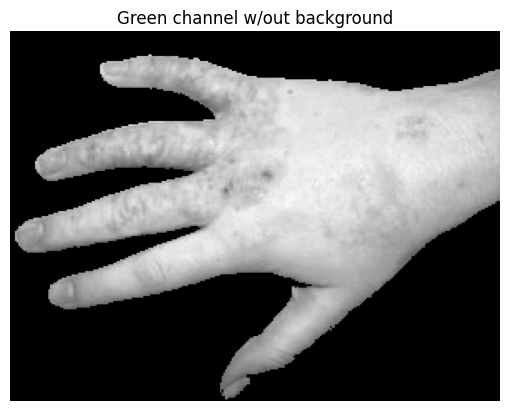

In [241]:
no_bg_img = select_hand(mask, img[:, :, 1], channels=1) # green channel image without background
plt.imshow(no_bg_img, cmap='gray'), plt.title('Green channel w/out background'), plt.axis('off')

### Multi-thresholding of green channel image

(<matplotlib.image.AxesImage at 0x2d343139160>,
 Text(0.5, 1.0, 'Green channel thresholded'),
 (-0.5, 293.5, 221.5, -0.5))

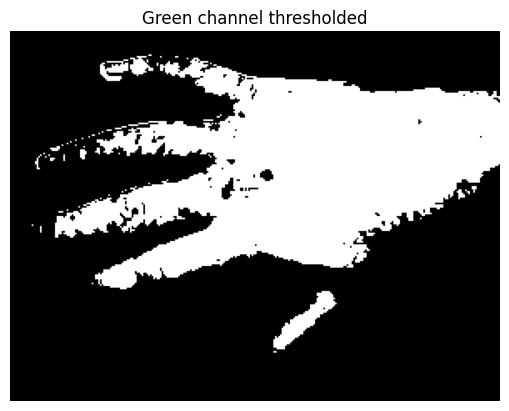

In [242]:
green_threshold = threshold_multiotsu(no_bg_img)
green_img_thresholded =  (no_bg_img > green_threshold[1]) # (no_bg_img > green_threshold[0]) &
plt.figure()
plt.imshow(green_img_thresholded, cmap='gray'), plt.title('Green channel thresholded'), plt.axis('off')

## Equalize histogram of green channel


1.5321443892872466e-05 1.0


(<AxesSubplot:title={'center':'adapt'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'adapt'))

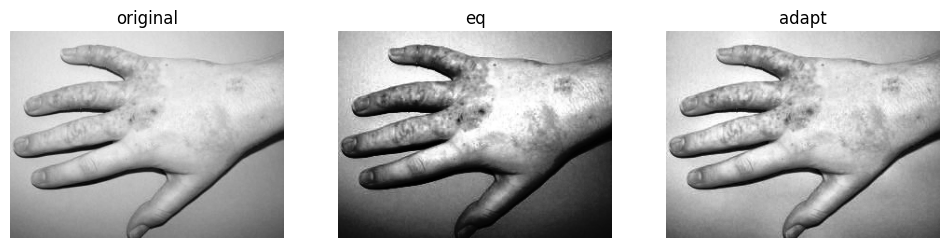

In [243]:
img_eq = exposure.equalize_hist(img[:, :, 1])
img_adapt = exposure.equalize_adapthist(img[:, :, 1], clip_limit=0.01)
print(np.min(img_eq), np.max(img_eq))
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(img[:, :, 1], cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 3, 2), plt.imshow(img_eq, cmap='gray'), plt.axis('off'), plt.title('eq')
plt.subplot(1, 3, 3), plt.imshow(img_adapt, cmap='gray'), plt.axis('off'), plt.title('adapt')

(<AxesSubplot:title={'center':'green adapt selected'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'green adapt selected'))

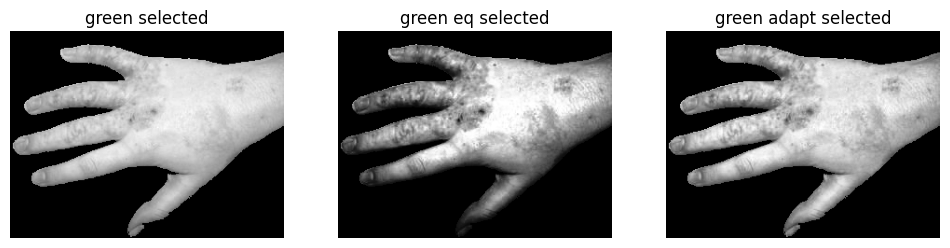

In [244]:
selected_eq = select_hand(mask, img_eq, dtype='float64') # USE THIS IMAGE
selected_adapt = select_hand(mask, img_adapt, dtype='float64') # USE THIS IMAGE

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(no_bg_img, cmap='gray'), plt.axis('off'), plt.title('green selected')
plt.subplot(1, 3, 2), plt.imshow(selected_eq, cmap='gray'), plt.axis('off'), plt.title('green eq selected')
plt.subplot(1, 3, 3), plt.imshow(selected_adapt, cmap='gray'), plt.axis('off'), plt.title('green adapt selected')


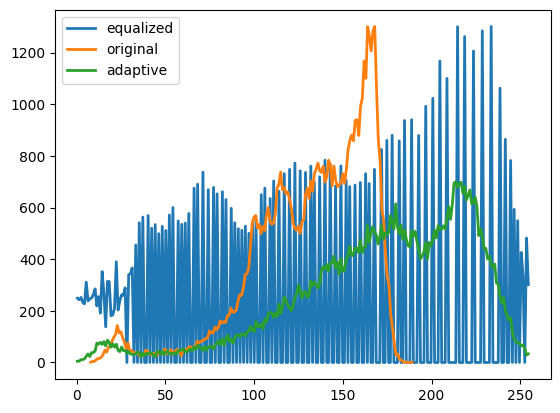

In [245]:
hist_eq, hist_centers_eq = exposure.histogram(img_eq)
hist_adapt, hist_centers_adapt = exposure.histogram(img_adapt)

plt.figure()
plt.plot(hist_centers_eq*255, hist_eq, lw=2, label='equalized')
plt.plot(hist_centers, hist, lw=2, label='original')
plt.plot(hist_centers_adapt*255, hist_adapt, lw=2, label='adaptive')
plt.legend()


### Multi otsu thresholding on modified images

[0.24804688 0.65820312] [0.27921134 0.68143188]


(<AxesSubplot:title={'center':'green adapt thresholded'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'green adapt thresholded'))

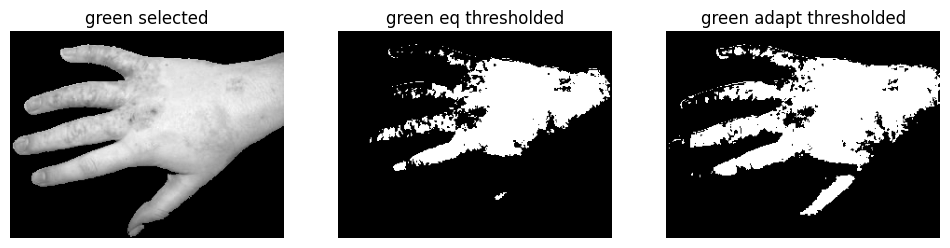

In [246]:
threshold_eq = threshold_multiotsu(selected_eq)
threshold_adapt = threshold_multiotsu(selected_adapt)
print(threshold_eq, threshold_adapt)
dermatitis_eq =(selected_eq > threshold_eq[1])
dermatitis_adapt =  (selected_adapt > threshold_adapt[1])

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(no_bg_img, cmap='gray'), plt.axis('off'), plt.title('green selected')
plt.subplot(1, 3, 2), plt.imshow(dermatitis_eq, cmap='gray'), plt.axis('off'), plt.title('green eq thresholded')
plt.subplot(1, 3, 3), plt.imshow(dermatitis_adapt, cmap='gray'), plt.axis('off'), plt.title('green adapt thresholded')

## HSV color space

(<AxesSubplot:title={'center':'V'}>,
 Text(0.5, 1.0, 'V'),
 (-0.5, 293.5, 221.5, -0.5))

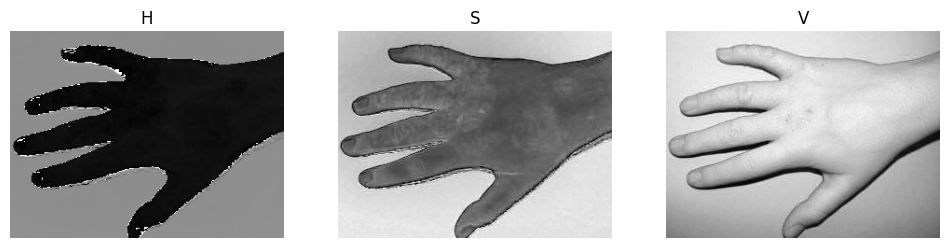

In [247]:
img = img[:, :, 0:3]
hsv_img = rgb2hsv(img)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(hsv_img[:, :, 0], cmap='gray'), plt.title('H'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(hsv_img[:, :, 1], cmap='gray'), plt.title('S'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(hsv_img[:, :, 2], cmap='gray'), plt.title('V'), plt.axis('off')

### Thresholding saturation channel without histogram modification

In [248]:
# PLOT HISTOGRAM
def plot_hist(img, title):
    plt.figure()
    plt.hist(img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()

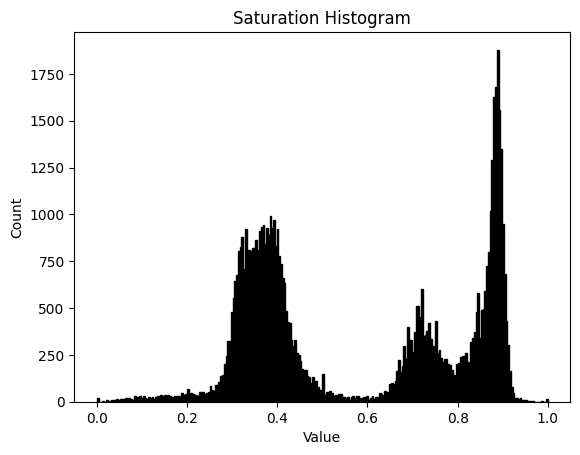

In [249]:
plot_hist(hsv_img[:, :, 1], 'Saturation Histogram')

#### Simple thresholding to remove the background

(<AxesSubplot:title={'center':'original'}>,
 Text(0.5, 1.0, 'original'))

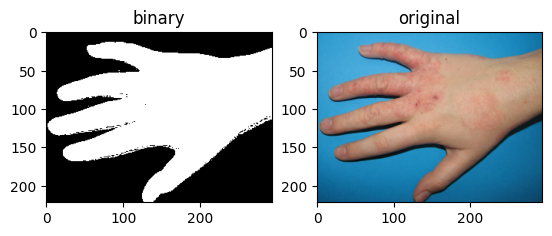

In [250]:
sat_img = hsv_img[:, :, 1]
thresh = threshold_otsu(sat_img)
binary = sat_img < thresh
plt.figure()
plt.subplot(1, 2, 1), plt.imshow(binary, cmap='gray'), plt.title('binary')
plt.subplot(1, 2, 2), plt.imshow(img), plt.title('original')

#### Multi Otsu thresholding to separate ill and healthy regions

(<AxesSubplot:title={'center':'sat multi thresholded'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'sat multi thresholded'))

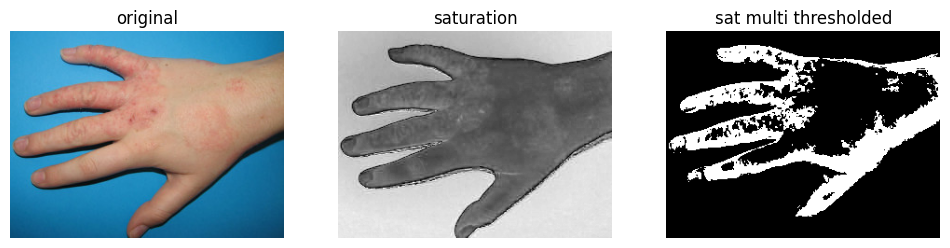

In [251]:
multi_threshold_sat = threshold_multiotsu(sat_img)
dermatitis_sat = (selected_eq > threshold_eq[0]) & (selected_eq < threshold_eq[1])

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 3, 2), plt.imshow(sat_img, cmap='gray'), plt.axis('off'), plt.title('saturation')
plt.subplot(1, 3, 3), plt.imshow(dermatitis_sat, cmap='gray'), plt.axis('off'), plt.title('sat multi thresholded')

### Thresholding after histogram modification on saturated image

(<AxesSubplot:title={'center':'equalized'}>,
 Text(0.5, 1.0, 'equalized'),
 (-0.5, 293.5, 221.5, -0.5))

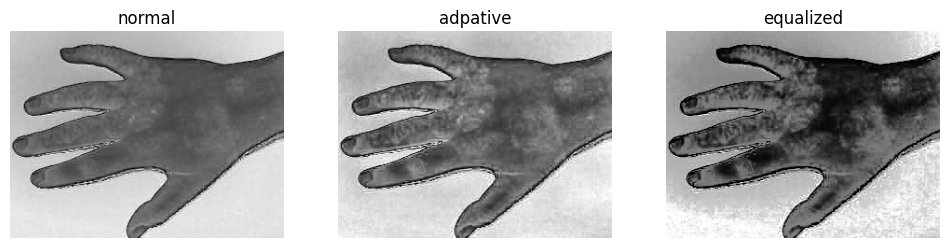

In [252]:
sat_img_adapt = exposure.equalize_adapthist(sat_img, clip_limit=0.01) # adaptive histogram equalization
sat_img_eq = exposure.equalize_hist(sat_img) # histogram equalization

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(sat_img, cmap='gray'), plt.title('normal'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(sat_img_adapt, cmap='gray'), plt.title('adpative'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(sat_img_eq, cmap='gray'), plt.title('equalized'), plt.axis('off')

### Selected hand after histogram equalization on saturation channel

(<AxesSubplot:title={'center':'green equalized selected'}>,
 Text(0.5, 1.0, 'green equalized selected'),
 (-0.5, 293.5, 221.5, -0.5))

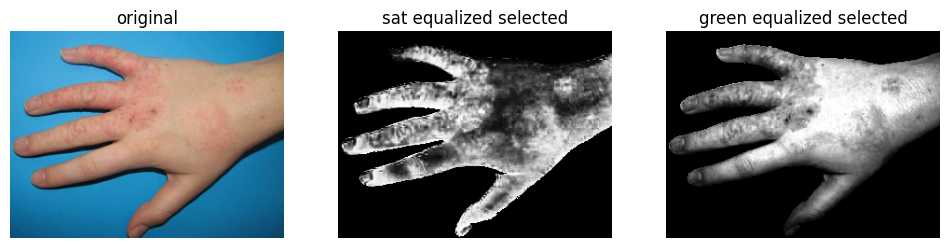

In [253]:
selected_sat_eq = select_hand(mask, sat_img_eq, dtype='float64')
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(selected_sat_eq, cmap='gray'), plt.title('sat equalized selected'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(selected_eq, cmap='gray'), plt.title('green equalized selected'), plt.axis('off')

#### Thresholding the selected hand using multi-otsu algorithm 

(<AxesSubplot:title={'center':'green equalized selected'}>,
 Text(0.5, 1.0, 'green equalized selected'),
 (-0.5, 293.5, 221.5, -0.5))

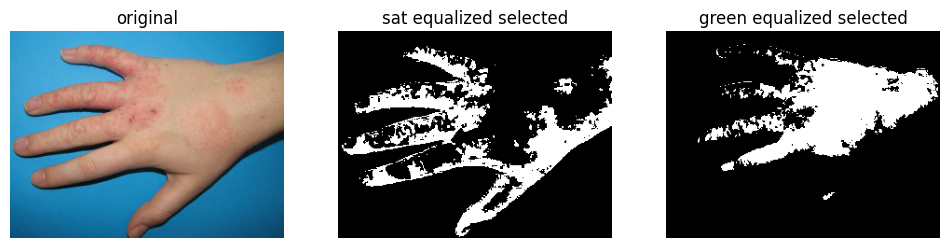

In [254]:
multi_threshold_sat_eq = threshold_multiotsu(selected_sat_eq)
dermatitis_sat_eq = (selected_sat_eq > multi_threshold_sat_eq[1])
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(dermatitis_sat_eq, cmap='gray'), plt.title('sat equalized selected'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(dermatitis_eq, cmap='gray'), plt.title('green equalized selected'), plt.axis('off')

## Log correction

In [255]:
from skimage import img_as_float

def plot_img_and_hist(image, axes, bins=256, printCDF=False):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    if printCDF:
        ax_cdf = ax_hist.twinx()
        img_cdf, bins = exposure.cumulative_distribution(image, bins)
        ax_cdf.plot(bins, img_cdf, 'r')
        ax_cdf.set_yticks([])
        return ax_img, ax_hist, ax_cdf
    else:
        return ax_img, ax_hist

In [256]:
def log_correction(img):
    img = img/np.max(img)

    # log-correction is performed
    img_log_corrected = 0.7*(np.log(1+img))/np.log(1+np.max(img))

    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 2), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 2, 1)
    for i in range(1, 2):
        axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 2):
        axes[1, i] = fig.add_subplot(2, 2, 3+i)

    ax_img, ax_hist = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast dark image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist = plot_img_and_hist(img_log_corrected, axes[:, 1])
    ax_img.set_title('Log correction')

    return img_log_corrected

### Green channel

C:\Users\flore\AppData\Local\Temp\ipykernel_16080\2110597581.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 2), dtype=np.object)


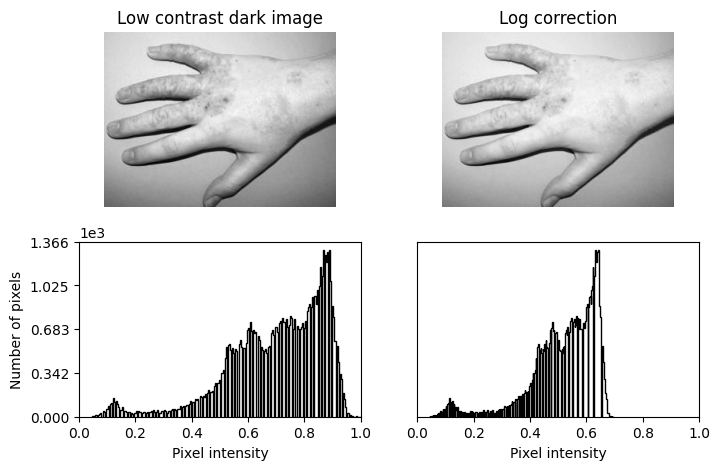

In [257]:
green_log_corrected = log_correction(img[:, :, 1])

(<AxesSubplot:title={'center':'adapt'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'adapt'))

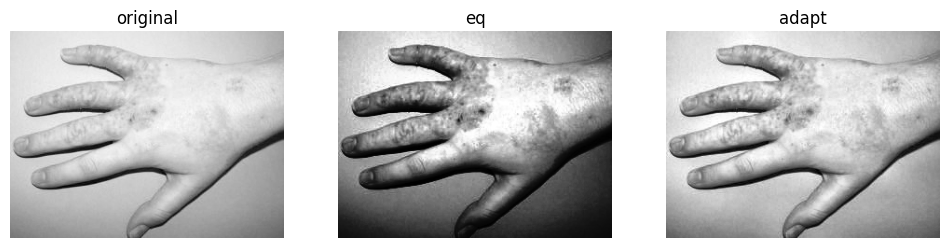

In [258]:
img_eq = exposure.equalize_hist(green_log_corrected)
img_adapt = exposure.equalize_adapthist(green_log_corrected, clip_limit=0.01)
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(green_log_corrected, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 3, 2), plt.imshow(img_eq, cmap='gray'), plt.axis('off'), plt.title('eq')
plt.subplot(1, 3, 3), plt.imshow(img_adapt, cmap='gray'), plt.axis('off'), plt.title('adapt')

### Log correction on saturation

C:\Users\flore\AppData\Local\Temp\ipykernel_16080\2110597581.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 2), dtype=np.object)


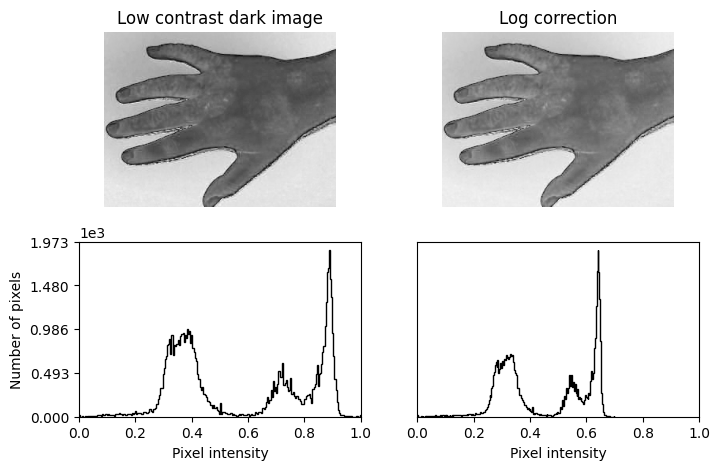

In [259]:
sat_log = log_correction(sat_img)

## Sigmoid correction

In [260]:
def sigmoid_correction(img, cutoff=0.5, gain=10):

    img_sig_corrected = exposure.adjust_sigmoid(img, cutoff=cutoff, gain=gain, inv=False)

    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 2), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 2, 1)
    for i in range(1, 2):
        axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 2):
        axes[1, i] = fig.add_subplot(2, 2, 3+i)

    ax_img, ax_hist = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast dark image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist = plot_img_and_hist(img_sig_corrected, axes[:, 1])
    ax_img.set_title('Sigmoid correction')

    return img_sig_corrected

C:\Users\flore\AppData\Local\Temp\ipykernel_16080\2205129462.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 2), dtype=np.object)


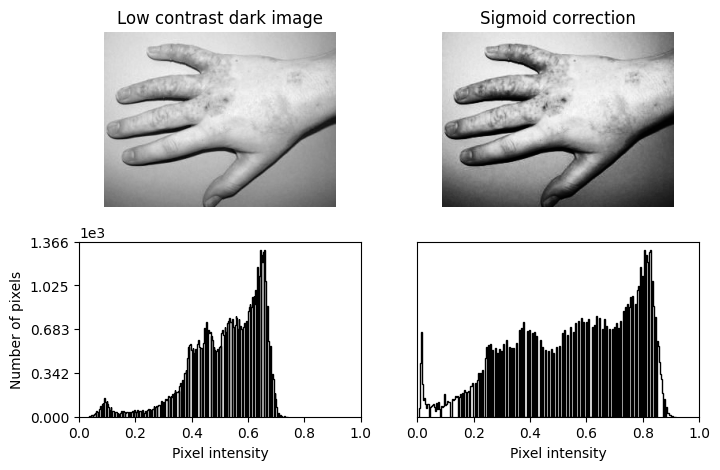

In [261]:
green_sig = sigmoid_correction(img[:, :, 1], cutoff=0.5, gain=10)

### Lab color space
#### Images

(222, 294, 3)


(<AxesSubplot:title={'center':'Original'}>,
 Text(0.5, 1.0, 'Original'),
 (-0.5, 293.5, 221.5, -0.5))

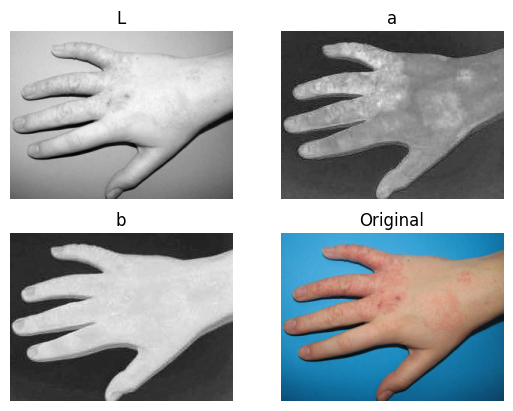

In [262]:
import cv2

image = cv2.imread('atopic_dermatitis_hand.jpg')

lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)# Convert RGB to LAB

print(lab_image.shape)

plt.subplot(2, 2, 1), plt.imshow(lab_image[:, :, 0], cmap='gray'), plt.title('L'), plt.axis('off')
plt.subplot(2, 2, 2), plt.imshow(lab_image[:, :, 1], cmap='gray'), plt.title('a'), plt.axis('off')
plt.subplot(2, 2, 3), plt.imshow(lab_image[:, :, 2], cmap='gray'), plt.title('b'), plt.axis('off')
plt.subplot(2, 2, 4), plt.imshow(img), plt.title('Original'), plt.axis('off')

#### Histograms

C:\Users\flore\AppData\Local\Temp\ipykernel_16080\3034294529.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 2), dtype=np.object)


Text(0.5, 1.0, 'a channel')

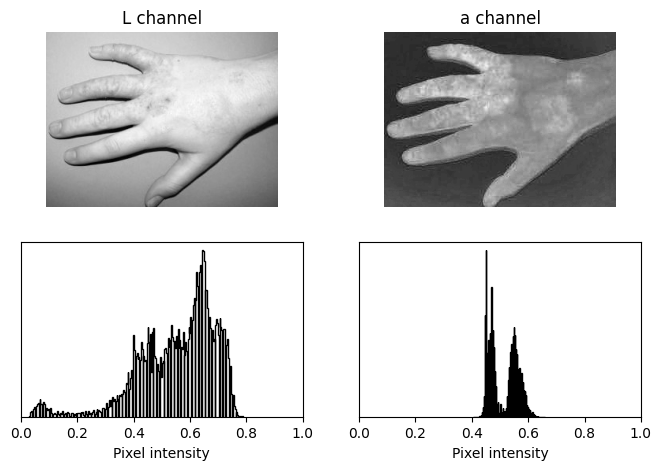

In [263]:
# plot the histogram of all the lab_img using plot_img_and_hist function
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)
ax_img, ax_hist = plot_img_and_hist(lab_image[:, :, 0], axes[:, 0])
ax_img.set_title('L channel')
ax_img, ax_hist = plot_img_and_hist(lab_image[:, :, 1], axes[:, 1])
ax_img.set_title('a channel')

#### Multi-otsu threshold (3 classes) using the "a" channel of the Lab color space

(<AxesSubplot:title={'center':'Original image'}>,
 (-0.5, 293.5, 221.5, -0.5),
 Text(0.5, 1.0, 'Original image'))

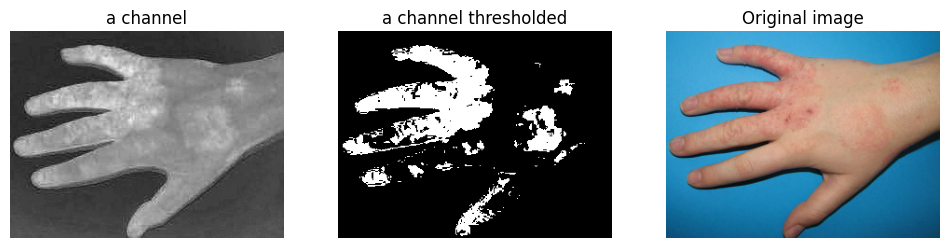

In [264]:
multi_threshold_lab = threshold_multiotsu(lab_image[:, :, 1])
thresholded_lab = lab_image[:, :, 1] > multi_threshold_lab[1]
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(lab_image[:, :, 1], cmap='gray'), plt.axis('off'), plt.title('a channel')
plt.subplot(1, 3, 2), plt.imshow(thresholded_lab, cmap='gray'), plt.axis('off'), plt.title('a channel thresholded')
plt.subplot(1, 3, 3), plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title('Original image')

## Region growing algorithm
### Choose seeds

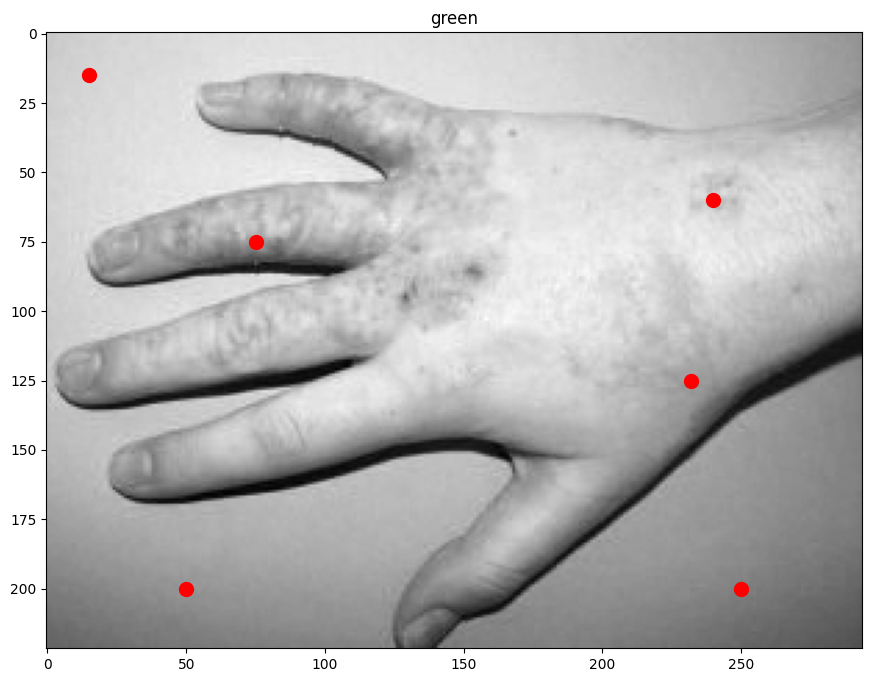

In [265]:
img = skio.imread('atopic_dermatitis_hand.jpg', as_gray=False)
# we need 2 seeds for the background (because regions are not merging), one on the hand, three on the dermatitis
plt.figure(figsize=(12, 8))
plt.imshow(img[:, :, 1], cmap='gray'), plt.title('green')

seeds = [(15, 15), (250, 200), (75, 75), (232, 125),  (240, 60), (50, 200)]
for seed in seeds:
    plt.plot(seed[0], seed[1], 'ro', markersize=10)  # 'ro' means red color, circle marker

# Breast cancer ultrasound image

In [266]:
img = skio.imread('malignant (17).png', as_gray=False) # CHANGE FILENAME

### Choose seeds position
Only one seed in the tumor

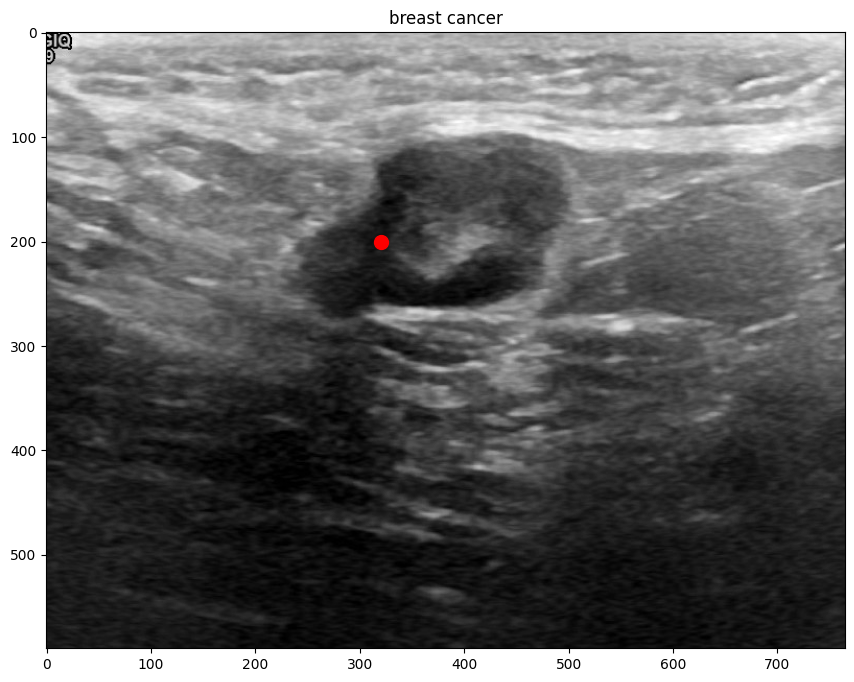

In [267]:
plt.figure(figsize=(12, 8))
plt.imshow(img[:, :, 1], cmap='gray'), plt.title('breast cancer')

seeds = [(320, 200)]
for seed in seeds:
    plt.plot(seed[0], seed[1], 'ro', markersize=10)  # 'ro' means red color, circle marker

In [268]:
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma


noisy = skio.imread('malignant (17).png', as_gray=True)
print(noisy.shape)
sigma = 0.08

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(noisy, h=0.6 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6),
                       sharex=True, sharey=True)

ax[0, 0].imshow(noisy, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('original')
ax[0, 1].imshow(denoise, cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')
ax[0, 2].imshow(denoise2, cmap='gray')
ax[0, 2].axis('off')
ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
ax[1, 0].imshow(noisy, cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('original')
ax[1, 1].imshow(denoise_fast, cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')
ax[1, 2].imshow(denoise2_fast, cmap='gray')
ax[1, 2].axis('off')
ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()

plt.show()

(590, 765)
estimated noise standard deviation = 0.0016221781760386684


KeyboardInterrupt: 

In [ ]:
# normaliser toutes les images

noisy = noisy / np.max(noisy)
denoise = denoise / np.max(denoise)
denoise2 = denoise2 / np.max(denoise2)
denoise_fast = denoise_fast / np.max(denoise_fast)
denoise2_fast = denoise2_fast / np.max(denoise2_fast)


In [ ]:
from skimage import metrics

print(denoise.shape)

psnr_noisy = metrics.peak_signal_noise_ratio(noisy, denoise)
psnr_noisy2 = metrics.peak_signal_noise_ratio(noisy, denoise2)
psnr_noisy3 = metrics.peak_signal_noise_ratio(noisy, denoise_fast)
psnr_noisy4 = metrics.peak_signal_noise_ratio(noisy, denoise2_fast)

ssim_noisy = metrics.structural_similarity(noisy, denoise)
ssim_noisy2 = metrics.structural_similarity(noisy, denoise2)
ssim_noisy3 = metrics.structural_similarity(noisy, denoise_fast)
ssim_noisy4 = metrics.structural_similarity(noisy, denoise2_fast)

print(f'PSNR noisy = {psnr_noisy}')
print(f'PSNR noisy2 = {psnr_noisy2}')
print(f'PSNR noisy3 = {psnr_noisy3}')
print(f'PSNR noisy4 = {psnr_noisy4}')

print(f'SSIM noisy = {ssim_noisy}')
print(f'SSIM noisy2 = {ssim_noisy2}')
print(f'SSIM noisy3 = {ssim_noisy3}')
print(f'SSIM noisy4 = {ssim_noisy4}')


(590, 765)
PSNR noisy = 86.15154360536872
PSNR noisy2 = 82.62464742600545
PSNR noisy3 = 87.62587938633216
PSNR noisy4 = 79.02013277997543
SSIM noisy = 0.9999994301625352
SSIM noisy2 = 0.9999987552275782
SSIM noisy3 = 0.9999996026273907
SSIM noisy4 = 0.9999971715085635


Here we show the lowest PSNR structural similarity (because we compare with an already noised image). Therefore, we select denoise image using fast NLM algorithm.

### Histogram equalization

(<Axes: title={'center': 'eq'}>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'eq'))

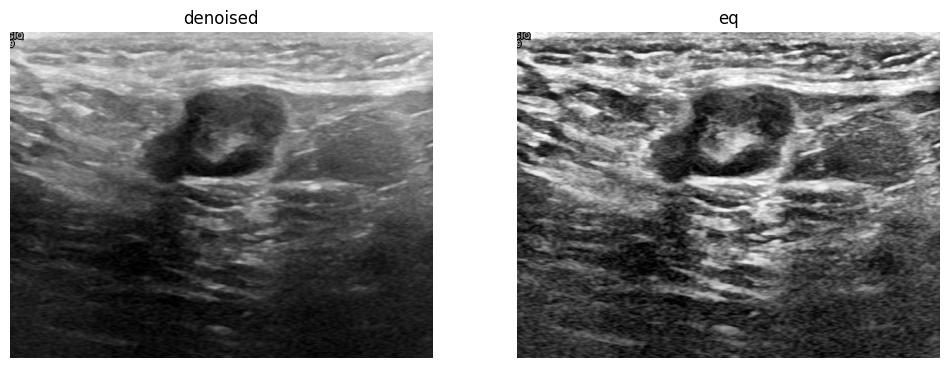

In [ ]:
eq_denoise = exposure.equalize_adapthist(denoise2_fast)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(denoise2_fast, cmap='gray'), plt.axis('off'), plt.title('denoised')
plt.subplot(1, 2, 2), plt.imshow(eq_denoise, cmap='gray'), plt.axis('off'), plt.title('eq')


(<Axes: title={'center': 'eq'}>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'eq'))

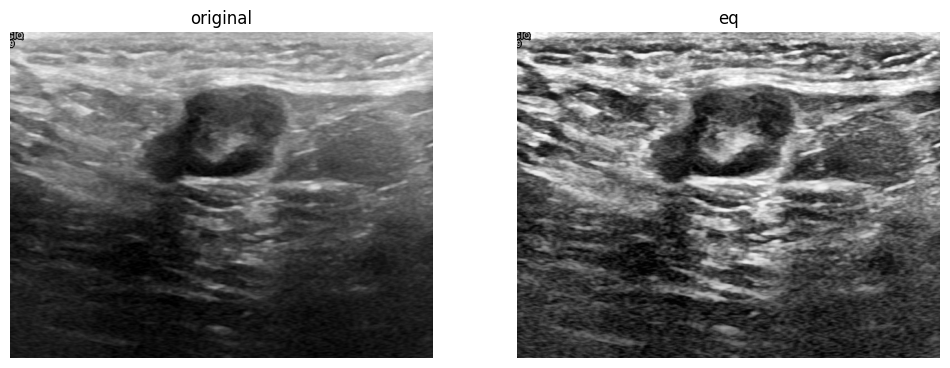

In [ ]:
eq_noisy = exposure.equalize_adapthist(noisy)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(eq_noisy, cmap='gray'), plt.axis('off'), plt.title('eq')

## Preprocess region growing of ultrasound image

(<AxesSubplot:title={'center':'filled'}>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'filled'))

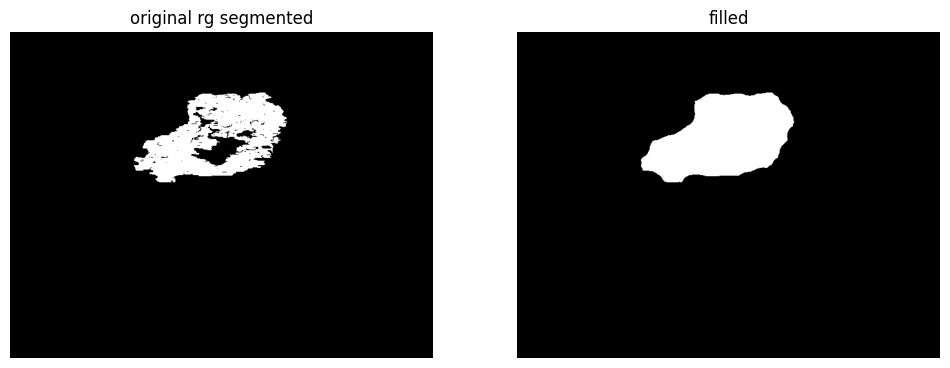

In [ ]:
rg_segmented = skio.imread('rg_us_segmented.png', as_gray=True)

circle = skmorph.disk(8)
filled_img = skmorph.closing(rg_segmented, circle)

circle2 = skmorph.disk(20)
filled_img = skmorph.closing(rg_segmented, circle2)


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(rg_segmented, cmap='gray'), plt.axis('off'), plt.title('original rg segmented')
plt.subplot(1, 2, 2), plt.imshow(filled_img, cmap='gray'), plt.axis('off'), plt.title('filled')

In [ ]:
import tensorflow.keras.metrics as tf_metrics
from sklearn.metrics import accuracy_score


def disp_iou_accu(img, mask):
    img = img / np.max(img)
    mask = mask / np.max(mask)
    m = tf_metrics.MeanIoU(num_classes=2)
    m.update_state(mask, img)
    print("IoU:", m.result().numpy())
    Accuracy = accuracy_score(mask, img)
    print(f'Accuracy: {Accuracy}')

mask = skio.imread('malignant (17)_mask.png', as_gray=True)
disp_iou_accu(filled_img, mask)

NameError: ignored

## Thresholding

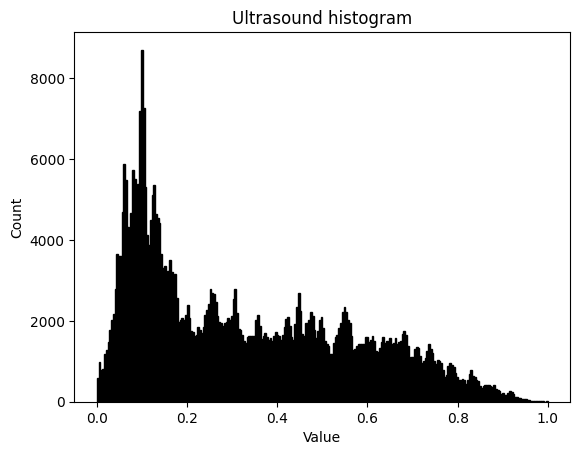

In [ ]:
plot_hist(noisy, 'Ultrasound histogram')

IoU: 0.25390145
Accuracy: 0.10677966101694915


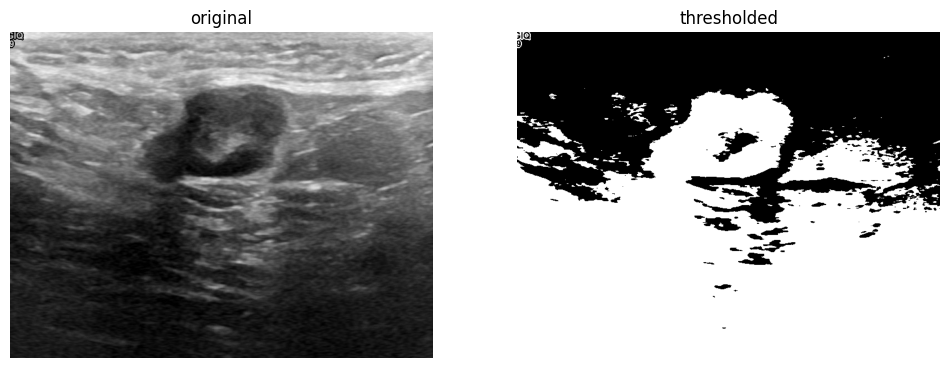

In [ ]:
noisy = skio.imread('malignant (17).png', as_gray=True)
us_threshold = threshold_otsu(noisy)
us_thresholded = (noisy < us_threshold)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(us_thresholded, cmap='gray'), plt.axis('off'), plt.title('thresholded')
disp_iou_accu(us_thresholded, mask)

IoU: 0.47473443
Accuracy: 0.2271186440677966


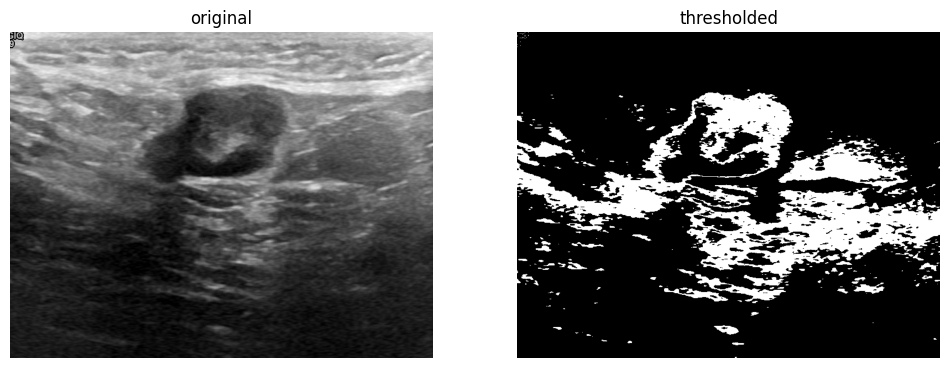

In [ ]:
us_threshold = threshold_multiotsu(noisy, 5)
us_thresholded = (noisy > us_threshold[0]) & (noisy < us_threshold[1])
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(us_thresholded, cmap='gray'), plt.axis('off'), plt.title('thresholded')
disp_iou_accu(us_thresholded, mask)

IoU: 0.40167066
Accuracy: 0.19322033898305085


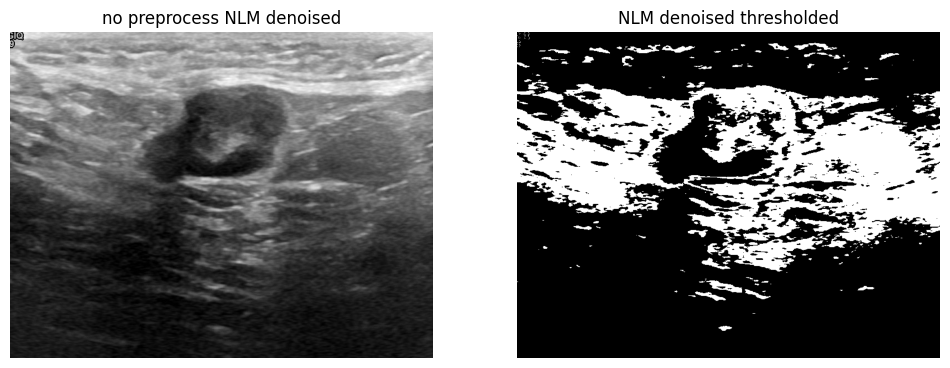

In [ ]:
denoised_threshold = threshold_multiotsu(denoise2_fast)
denoised_thresholded = (denoise2_fast > denoised_threshold[0]) & (denoise2_fast < denoised_threshold[1])
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(denoise2_fast, cmap='gray'), plt.axis('off'), plt.title('no preprocess NLM denoised')
plt.subplot(1, 2, 2), plt.imshow(denoised_thresholded, cmap='gray'), plt.axis('off'), plt.title('NLM denoised thresholded')
disp_iou_accu(denoised_thresholded, mask)

IoU: 0.2942315
Accuracy: 0.11186440677966102


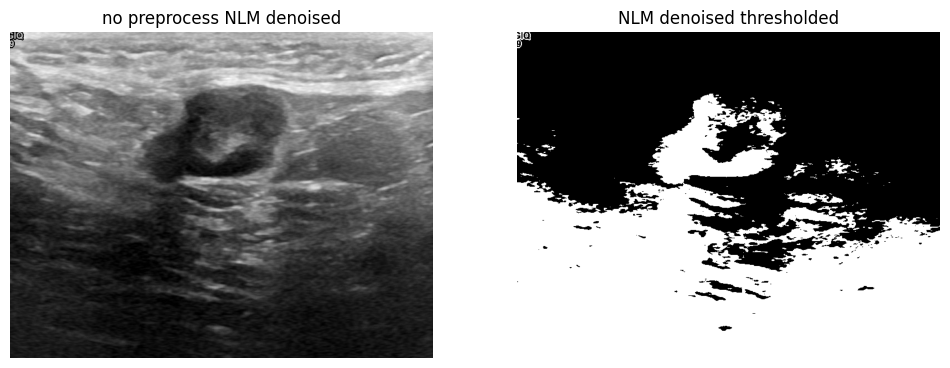

In [ ]:
denoised_thresholded = (denoise2_fast < denoised_threshold[0])
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(denoise2_fast, cmap='gray'), plt.axis('off'), plt.title('no preprocess NLM denoised')
plt.subplot(1, 2, 2), plt.imshow(denoised_thresholded, cmap='gray'), plt.axis('off'), plt.title('NLM denoised thresholded')
disp_iou_accu(denoised_thresholded, mask)

IoU: 0.38389045
Accuracy: 0.011864406779661017


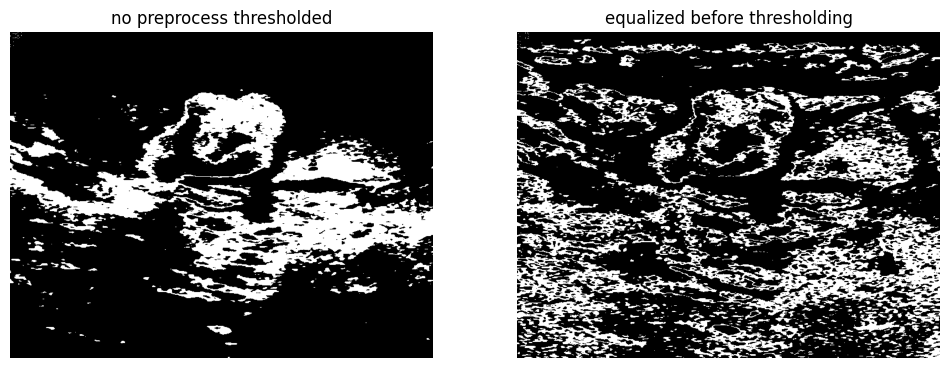

In [ ]:
eq_threshold = threshold_multiotsu(eq_denoise, 5)
eq_thresholded = (eq_denoise > eq_threshold[0]) & (eq_denoise < eq_threshold[1])

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(us_thresholded, cmap='gray'), plt.axis('off'), plt.title('no preprocess thresholded')
plt.subplot(1, 2, 2), plt.imshow(eq_thresholded, cmap='gray'), plt.axis('off'), plt.title('equalized before thresholding')
disp_iou_accu(eq_thresholded, mask)

### Low band thresholding

IoU: 0.39771324
Accuracy: 0.022033898305084745


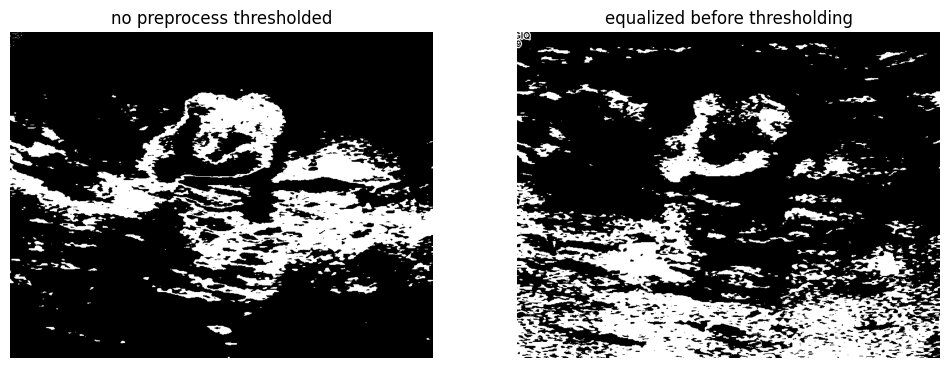

In [ ]:
eq_threshold = threshold_multiotsu(eq_denoise, 5)
eq_thresholded = (eq_denoise < eq_threshold[0])
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(us_thresholded, cmap='gray'), plt.axis('off'), plt.title('no preprocess thresholded')
plt.subplot(1, 2, 2), plt.imshow(eq_thresholded, cmap='gray'), plt.axis('off'), plt.title('equalized before thresholding')
disp_iou_accu(eq_thresholded, mask)

### Medium band thresholding

IoU: 0.35231978
Accuracy: 0.00847457627118644


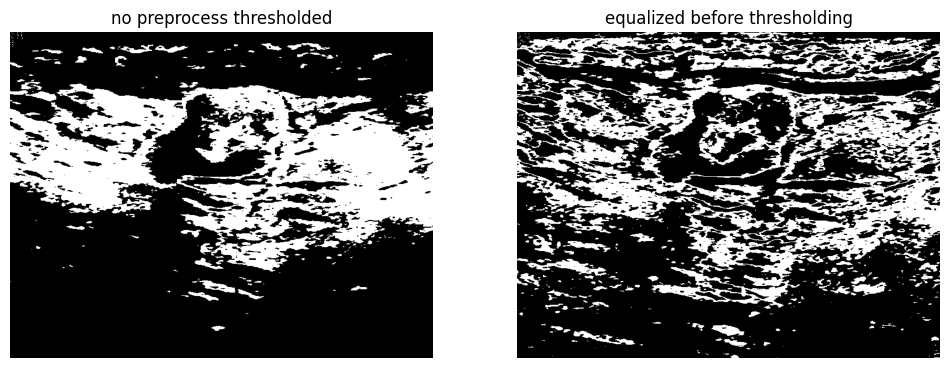

In [ ]:
eq_threshold = threshold_multiotsu(eq_noisy)
eq_thresholded = (eq_noisy > eq_threshold[0]) & (eq_noisy < eq_threshold[1])

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(us_thresholded, cmap='gray'), plt.axis('off'), plt.title('no preprocess thresholded')
plt.subplot(1, 2, 2), plt.imshow(eq_thresholded, cmap='gray'), plt.axis('off'), plt.title('equalized before thresholding')
disp_iou_accu(eq_thresholded, mask)

## Low part darkness correction 

(<Axes: title={'center': 'corrected'}>,
 (-0.5, 764.5, 294.5, -0.5),
 Text(0.5, 1.0, 'corrected'))

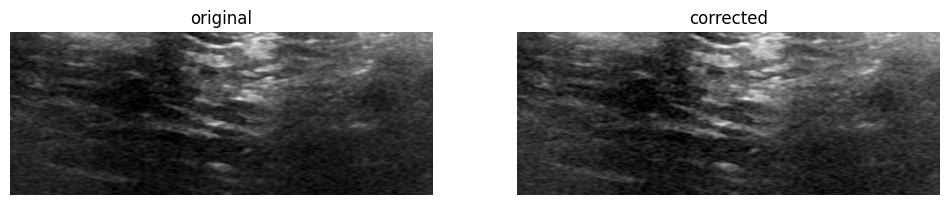

In [ ]:
low_part = noisy[round(noisy.shape[0]/2):noisy.shape[0], :]
corrected_low_part = np.log(1+low_part)/np.log(1+np.max(low_part))
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(low_part, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(corrected_low_part, cmap='gray'), plt.axis('off'), plt.title('corrected')

In [ ]:
def gamma_correction(img, gamma=0.5):

    img_log = np.log(img)*gamma
    img_gamma_corrected = np.exp(img_log)

    return img_gamma_corrected

<ipython-input-40-08c05166276e>:3: RuntimeWarning: divide by zero encountered in log
  img_log = np.log(img)*gamma


(<Axes: title={'center': 'gamma corrected'}>,
 (-0.5, 764.5, 294.5, -0.5),
 Text(0.5, 1.0, 'gamma corrected'))

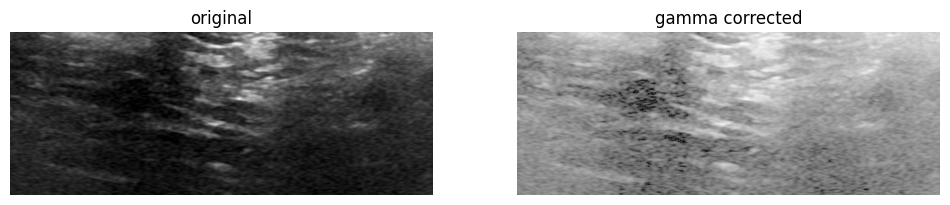

In [ ]:
exp_low_part = gamma_correction(low_part, gamma=0.3)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(low_part, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(exp_low_part, cmap='gray'), plt.axis('off'), plt.title('gamma corrected')

(<Axes: title={'center': 'corrected'}>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'corrected'))

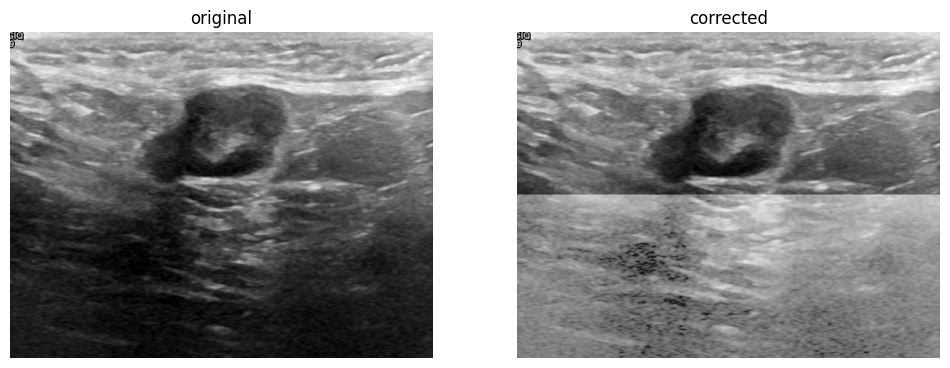

In [ ]:
white_noisy = np.copy(noisy)
white_noisy[round(noisy.shape[0]/2):noisy.shape[0], :] = exp_low_part
white_noisy[0:round(noisy.shape[0]/2), :] = noisy[0:round(noisy.shape[0]/2), :]
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(white_noisy, cmap='gray'), plt.axis('off'), plt.title('corrected')

### Thresholding of the low-part-corrected image 

IoU: 0.6128664
Accuracy: 0.1711864406779661


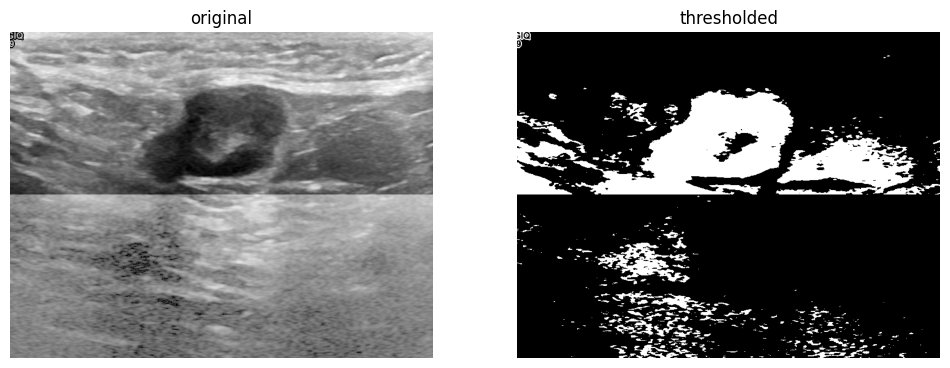

In [ ]:
threshold = threshold_multiotsu(white_noisy)
segmented = (white_noisy < threshold[0]) # (white_noisy > threshold[0]) &
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(white_noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(segmented, cmap='gray'), plt.axis('off'), plt.title('thresholded')
disp_iou_accu(segmented, mask)

### Preprocessing of the thresholded ultrasound image 

IoU: 0.7417568
Accuracy: 0.6644067796610169


(<matplotlib.image.AxesImage at 0x2d2018d2f40>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'preprocess image'))

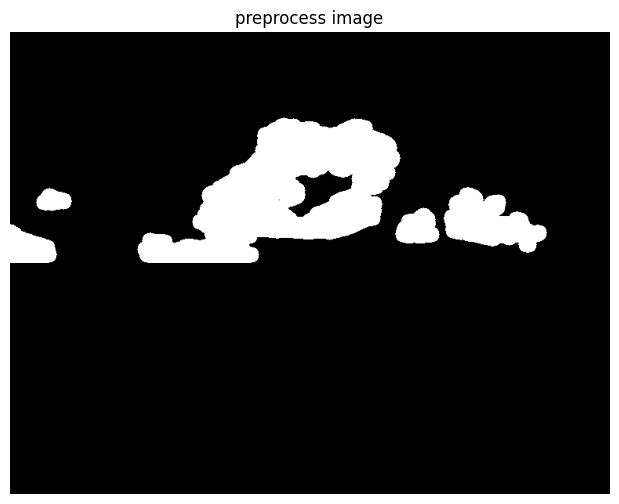

In [ ]:
circle = skmorph.disk(10)
filled_img1 = skmorph.opening(segmented, circle)
disp_iou_accu(filled_img1, mask)
plt.figure(figsize=(8, 6))
plt.imshow(filled_img1, cmap='gray'), plt.axis('off'), plt.title('preprocess image')


### Chan Vese algorithm on well thresholded ultrasound image


In [ ]:
from skimage.segmentation import chan_vese

cv = chan_vese(noisy, mu=0.5, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=1000, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

IoU: 0.26953676
Accuracy: 0.13559322033898305


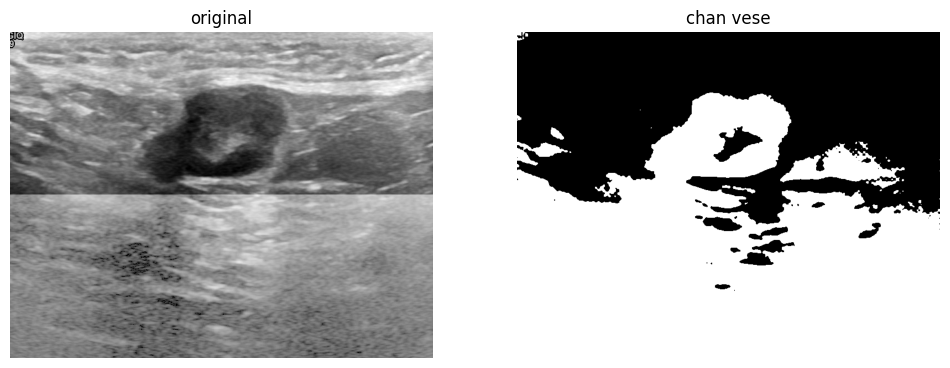

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(white_noisy, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(cv[0], cmap='gray'), plt.axis('off'), plt.title('chan vese')
disp_iou_accu(cv[0], mask)

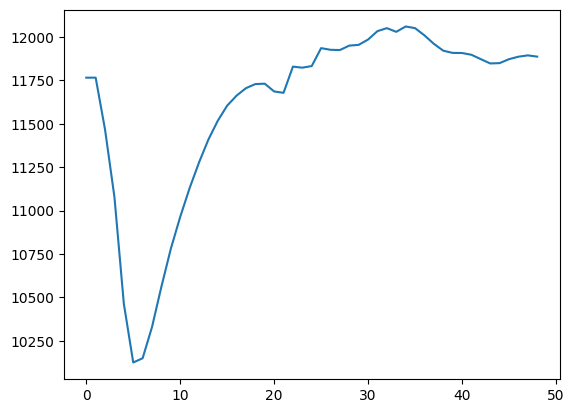

In [ ]:
plt.plot(cv[2])

In [ ]:
cv = chan_vese(segmented, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

(<AxesSubplot:title={'center':'chan vese'}>,
 (-0.5, 764.5, 589.5, -0.5),
 Text(0.5, 1.0, 'chan vese'))

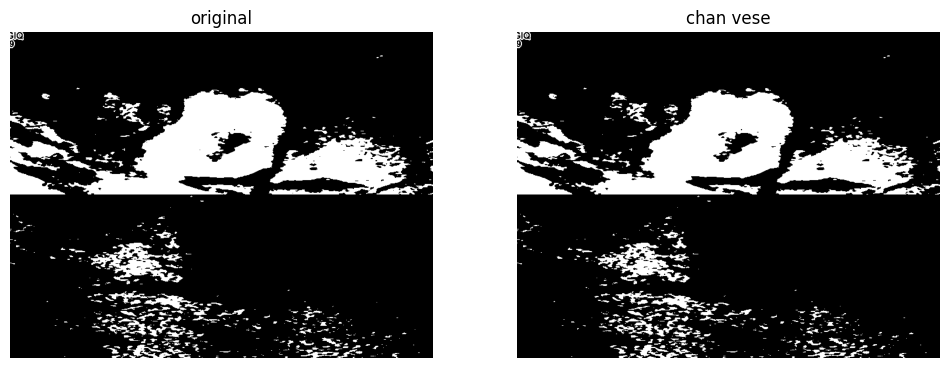

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1), plt.imshow(segmented, cmap='gray'), plt.axis('off'), plt.title('original')
plt.subplot(1, 2, 2), plt.imshow(cv[0], cmap='gray'), plt.axis('off'), plt.title('chan vese')

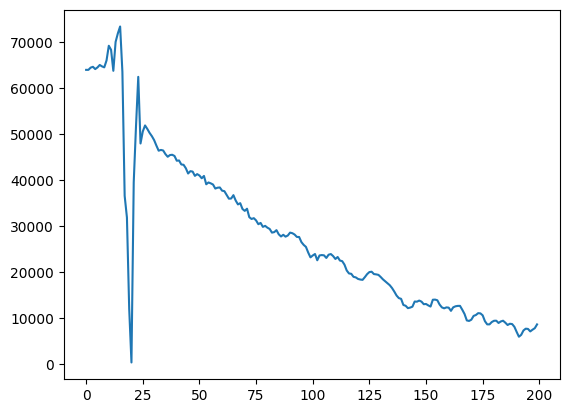

In [ ]:
plt.plot(cv[2])

### Algo from github
see RegionGrowing.py

# Kmeans

In [ ]:
from sklearn import cluster
from skimage import img_as_float

def k_means(img, k=2):

    img = img / np.max(img)

    img = img_as_float(img)

    # k-means clustering of the image
    X = img.reshape((-1, 1))
    k_means = cluster.KMeans(init="k-means++", n_clusters=k, n_init=3, random_state=0) # use 3 clusters for the toyobjects image, for leopard too (dilatation and closing works best)
    # 2 for bacteria (dilatation fills the bacteria holes )

    k_means.fit(X)

    # extract means of each cluster & clustered population
    clusters_means = k_means.cluster_centers_.squeeze()
    X_clustered = k_means.labels_
    print('# of Observations:', X.shape)
    print('Clusters Means:', clusters_means)

    return X_clustered.reshape(img.shape)


## AD hand

In [286]:
img = skio.imread('atopic_dermatitis_hand.jpg', as_gray=False)

### K-means on "a" channel of the dermatitis hand image

# of Observations: (65268, 1)
Clusters Means: [0.70424237 0.87684405 0.8232914 ]


(<AxesSubplot:title={'center':'Selected Cluster'}>,
 Text(0.5, 1.0, 'Selected Cluster'),
 (-0.5, 293.5, 221.5, -0.5))

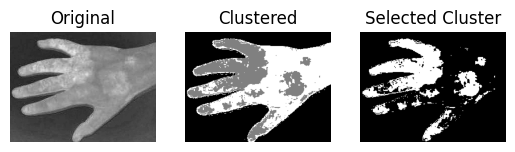

In [287]:
a_kmeans_img = k_means(lab_image[:, :, 1], k=3)
a_kmeans_img_thresholded = (a_kmeans_img == 1)

plt.figure()
plt.subplot(1, 3, 1), plt.imshow(lab_image[:, :, 1], cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(a_kmeans_img, cmap='gray'), plt.title('Clustered'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(a_kmeans_img_thresholded, cmap='gray'), plt.title('Selected Cluster'), plt.axis('off')

### K-means on green channel of the dermatitis hand image

# of Observations: (65268, 1)
Clusters Means: [0.82929231 0.60239887 0.27953486]


(<AxesSubplot:title={'center':'Selected Cluster'}>,
 Text(0.5, 1.0, 'Selected Cluster'),
 (-0.5, 293.5, 221.5, -0.5))

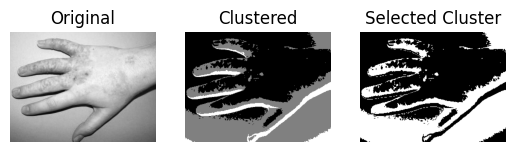

In [288]:
kmeans_img = k_means(img[:, :, 1], k=3)
kmeans_img_thresholded = (kmeans_img == 1)

plt.figure()
plt.subplot(1, 3, 1), plt.imshow(img[:, :, 1], cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(kmeans_img, cmap='gray'), plt.title('Clustered'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(kmeans_img_thresholded, cmap='gray'), plt.title('Selected Cluster'), plt.axis('off')

### Multi-Otsu vs K-means comparison

(<AxesSubplot:title={'center':'K-means'}>,
 Text(0.5, 1.0, 'K-means'),
 (-0.5, 293.5, 221.5, -0.5))

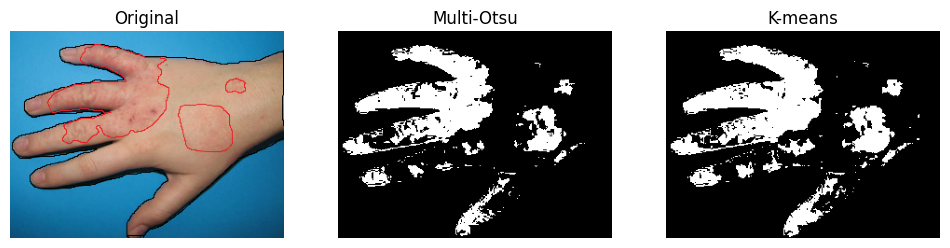

In [ ]:
labeled_img = skio.imread("atopic_dermatitis_hand_contour.png", as_gray=False)[:, :, 0:3] # CHANGE FILENAME

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(labeled_img), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(thresholded_lab, cmap='gray'), plt.title('Multi-Otsu'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(a_kmeans_img_thresholded, cmap='gray'), plt.title('K-means'), plt.axis('off')

### Ultrasound k-means

# of Observations: (451350, 1)
Clusters Means: [0.16113773 0.58728083]
(590, 765) (590, 765)
IoU: 0.25390145
Accuracy: 0.10677966101694915


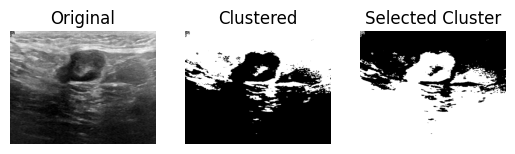

In [273]:
mask = skio.imread('malignant (17)_mask.png', as_gray=True) 

k_means_segmented = k_means(noisy, k=2)
k_means_segmented = k_means_segmented / np.max(k_means_segmented)
k_means_inverted = invert(k_means_segmented)

plt.figure()
plt.subplot(1, 3, 1), plt.imshow(noisy, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(k_means_segmented, cmap='gray'), plt.title('Clustered'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(k_means_inverted, cmap='gray'), plt.title('Selected Cluster'), plt.axis('off')
print(k_means_inverted.shape, mask.shape)
disp_iou_accu(k_means_inverted, mask)

# of Observations: (451350, 1)
Clusters Means: [0.64543995 0.39465895]
IoU: 0.35256618
Accuracy: 0.01864406779661017


(<AxesSubplot:title={'center':'Clustered'}>,
 Text(0.5, 1.0, 'Clustered'),
 (-0.5, 764.5, 589.5, -0.5))

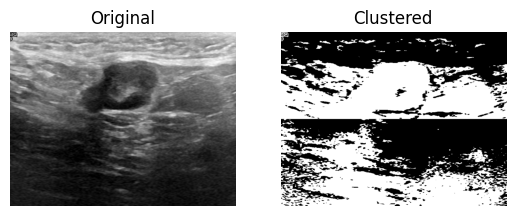

In [275]:
k_means_segmented = k_means(white_noisy, k=2)
k_means_segmented = k_means_segmented / np.max(k_means_segmented)
#k_means_segmented = invert(k_means_segmented)
disp_iou_accu(k_means_segmented, mask)
plt.figure()
plt.subplot(1, 2, 1), plt.imshow(noisy, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(k_means_segmented, cmap='gray'), plt.title('Clustered'), plt.axis('off')


# of Observations: (451350, 1)
Clusters Means: [0.70508991 0.49868519 0.27235055]
IoU: 0.6128664
Accuracy: 0.1711864406779661


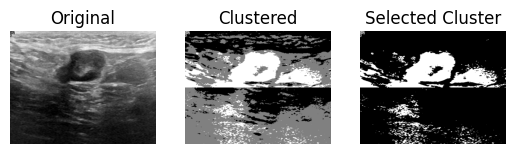

In [278]:
k_means_segmented = k_means(white_noisy, k=3)
kmeans_img_thresholded = (k_means_segmented == 2)
plt.figure()
plt.subplot(1, 3, 1), plt.imshow(noisy, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(k_means_segmented, cmap='gray'), plt.title('Clustered'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(kmeans_img_thresholded, cmap='gray'), plt.title('Selected Cluster'), plt.axis('off')
disp_iou_accu(kmeans_img_thresholded, mask)

# of Observations: (451350, 1)
Clusters Means: [0.40829982 0.65382497 0.21581418 0.52736605 0.79190416]
IoU: 0.6869435
Accuracy: 0.2542372881355932


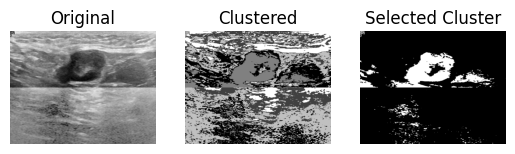

In [283]:
k_means_segmented = k_means(white_noisy, k=5)
kmeans_img_thresholded = (k_means_segmented == 2)
plt.figure()
plt.subplot(1, 3, 1), plt.imshow(white_noisy, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(k_means_segmented, cmap='gray'), plt.title('Clustered'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(kmeans_img_thresholded, cmap='gray'), plt.title('Selected Cluster'), plt.axis('off')
disp_iou_accu(kmeans_img_thresholded, mask)

# Snakes algorithm

## Breast cancer ultrasound image

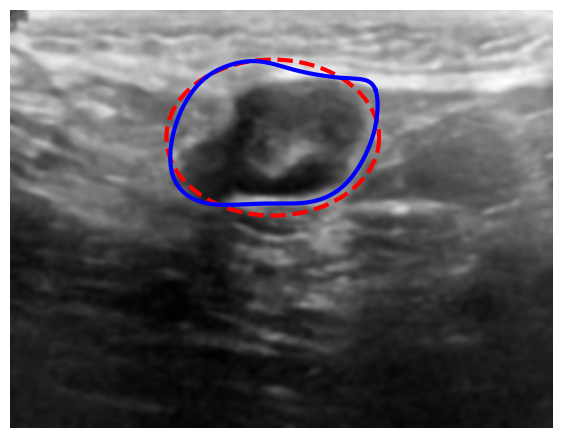

In [182]:
denoised = gaussian(noisy, 3, preserve_range=False)

s = np.linspace(0, 2*np.pi, 400)
r = 180 + 110*np.sin(s) #110
c = 370 + 150*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(denoised, init, alpha=0.01, beta=20, gamma=0.005, w_line=0.5, w_edge=1)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(denoised, cmap=plt.cm.gray), plt.axis('off')
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
plt.show()

In [179]:
def fill_snake_contour(snake, img_shape): 
    filled_img = np.zeros(img_shape)
    filled_img[snake[:, 0].astype(int), snake[:, 1].astype(int)] = 1
    kernel = np.ones((3,3),np.uint8)
    dilated_img = cv2.dilate(filled_img, kernel, iterations = 2)
    filled_img = flood_fill(dilated_img, (320, 200), 1)
    filled_img = invert(filled_img)
    
    return filled_img

In [183]:
filled_img = fill_snake_contour(snake, denoised.shape)

(<matplotlib.image.AxesImage at 0x2d31aaad2b0>, (-0.5, 764.5, 589.5, -0.5))

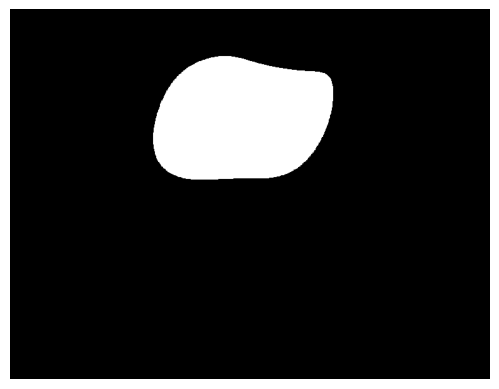

In [185]:
plt.imshow(filled_img, cmap='gray'), plt.axis('off')

In [186]:
disp_iou_accu(filled_img, mask)

IoU: 0.8665654
Accuracy: 0.6661016949152543


### Snake algorithm parameters search

In [173]:
results = pd.read_csv('results_snakesearch.csv')
df_sorted = results.sort_values(by=['iou', 'acc'], ascending=False)
df_sorted.head(5)

Unnamed: 0  alpha  beta  gamma  w_line  w_edge  sigma       iou       acc
263         263  0.010  20.0  0.005     0.5     1.0    3.0  0.866565  0.666102
47           47  0.015  10.0  0.005     0.5     1.0    3.0  0.862831  0.659322
209         209  0.010  10.0  0.005     0.5     1.0    3.0  0.861155  0.659322
353         353  0.020  10.0  0.010     0.5     1.0    3.0  0.859711  0.657627
371         371  0.020  10.0  0.005     0.5     1.0    3.0  0.859015  0.659322